In [43]:
# Setup PySpark and Spark NLP on Colab
!wget https://setup.johnsnowlabs.com/colab.sh -O - | bash
!pip install wordcloud     # wordcloud-1.9.3
!pip install plotly     # plotly-5.15.0

--2024-04-07 06:53:56--  https://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2024-04-07 06:53:56--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1191 (1.2K) [text/plain]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.16K  --.-KB/s    in 0s      

2024-04-07 06:53:56 (105 MB/s) - written to stdout [1191/1191]

Installin

In [ ]:
# Change the version of OpenJDK: for spark-nlp use only
# Colab crashes when restarting session
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# !update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
# !java -version

In [ ]:
# Change the version of python (After change, restart session): for spark-nlp use only
# Colab crashes when restarting session
# !sudo apt-get install python3.8
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 1

In [44]:
from pyspark import SparkConf, SparkContext, SQLContext
import re

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
import plotly.express as px

In [45]:
# Connect to google drive

from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
# Configuration
sc.stop()
conf = SparkConf()
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

In [51]:
import json

# Read the review file in Google Drive
review_path = "drive/MyDrive/yelp_academic_dataset_review.json"
review_rdd = sc.textFile(review_path)

# Parse json data within each record
review_rdd = review_rdd.map(lambda x: json.loads(x))
review_rdd = review_rdd.map(lambda x: (x['stars'],x['useful'],x['funny'],x['cool'],x['text']))

for row in review_rdd.take(10):
  print(row)

(3.0, 0, 0, 0, "If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.")
(5.0, 1, 0, 1, "I've taken a lot of spin classes over the years, and nothing compares to the classes at Body Cycle. From the nice, clean space and amazing bikes, to the welcoming and motivating instructors, every class is a top notch work out.\n\nFor anyone who struggles to fit workouts in, the online scheduling system makes it easy to plan ahead (and there's no need to line up way in advanced like many gyms make you do).\n\nThere is no way I can write this revi

In [7]:
# Preprocess
nltk.download('stopwords')

# Remove special characters
pattern = r'[^a-zA-Z0-9\s]'     # Define a pattern that only includes whitespaces and alphanumeric characters
def remove_special_characters(text):
    text = re.sub(pattern, ' ', text)     # Replace characters not belonging to the pattern with whitespace
    return text.replace('\n', ' ')      # Replace '\n' with whitespace

# Remove indepedent numbers and stopwords
def is_number(s):
    if s.isdigit():
        return True
    try:
        float(s)
        return True
    except:
        return False
stop_words = set(stopwords.words('english'))
stop_words.add('')
def remove_numbers_and_stopwords(text):
    return " ".join([x for x in text.split(' ') if not is_number(x) and x not in stop_words])

# Remove abundant spaces
def remove_extra_spaces(text):
    return " ".join(text.split(' '))

# Lemmatization
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split(" ")])

def preprocess(text):
    text = remove_special_characters(text)
    text = text.lower()
    text = remove_numbers_and_stopwords(text)
    text = remove_extra_spaces(text)
    text = lemmatize(text)
    return text

# Remove rows with empty word lists
def filter_empty_and_none(row):
    return row[4] is not None and len(row[4]) > 0

review_preprocessed_rdd = (
    review_rdd
    .map(lambda x : (int(x[0]), x[1], x[2], x[3], preprocess(x[4])))
    .filter(filter_empty_and_none)
)

for row in review_preprocessed_rdd.take(10):
  print(row)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


(3, 0, 0, 0, 'decide eat aware going take hour beginning end tried multiple time want like location nj never bad experience food good take long time come waitstaff young usually pleasant many experience spent way long waiting usually opt another diner restaurant weekend order done quicker')
(5, 1, 0, 1, 'taken lot spin class year nothing compare class body cycle nice clean space amazing bike welcoming motivating instructor every class top notch work anyone struggle fit workout online scheduling system make easy plan ahead need line way advanced like many gym make way write review without giving russell owner body cycle shout russell passion fitness cycling evident desire client succeed always dropping class check provide encouragement open idea recommendation anyone russell always wear smile face even kicking butt class')
(3, 0, 0, 0, 'family diner buffet eclectic assortment large chicken leg fried jalape tamale two rolled grape leaf fresh melon good lot mexican choice also menu breakf

In [ ]:
review_df = review_preprocessed_rdd.toDF(['stars', 'useful', 'funny', 'cool', 'text'])
review_df.show(10)

+-----+------+-----+----+--------------------+
|stars|useful|funny|cool|                text|
+-----+------+-----+----+--------------------+
|    3|     0|    0|   0|decide eat aware ...|
|    5|     1|    0|   1|taken lot spin cl...|
|    3|     0|    0|   0|family diner buff...|
|    5|     1|    0|   1|wow yummy differe...|
|    4|     1|    0|   1|cute interior own...|
|    1|     1|    2|   1|long term frequen...|
|    5|     0|    2|   0|loved tour grabbe...|
|    5|     2|    0|   0|amazingly amazing...|
|    3|     1|    1|   0|easter instead go...|
|    3|     0|    0|   0|party hibachi wai...|
+-----+------+-----+----+--------------------+
only showing top 10 rows



In [ ]:
star_counts = review_df.groupBy('stars').count()
star_counts.show()

+-----+-------+
|stars|  count|
+-----+-------+
|    5|3231542|
|    1|1069504|
|    3| 691899|
|    2| 544220|
|    4|1452848|
+-----+-------+



In [ ]:
useful_counts = review_df.groupBy('useful').count()
useful_counts.show()

+------+-------+
|useful|  count|
+------+-------+
|    29|    657|
|    19|   2780|
|    54|    109|
|     0|3840276|
|    22|   1781|
|     7|  47679|
|    34|    409|
|    32|    492|
|    31|    529|
|    25|   1149|
|     6|  71214|
|     9|  24783|
|    17|   3874|
|    28|    749|
|    33|    401|
|     5| 112204|
|     1|1539917|
|    10|  18474|
|    48|    139|
|    61|     57|
+------+-------+
only showing top 20 rows



In [ ]:
funny_counts = review_df.groupBy('funny').count()
funny_counts.show()

+-----+-------+
|funny|  count|
+-----+-------+
|   26|    274|
|   19|    599|
|    0|5893871|
|   22|    378|
|    7|  10178|
|   25|    281|
|    6|  15545|
|    9|   5223|
|   27|    252|
|   17|    781|
|    5|  24723|
|    1| 691983|
|   10|   3737|
|    3|  82110|
|   12|   2367|
|    8|   7147|
|   11|   2992|
|    2| 195283|
|    4|  42254|
|   13|   1896|
+-----+-------+
only showing top 20 rows



In [ ]:
cool_counts = review_df.groupBy('cool').count()
cool_counts.show()

+----+-------+
|cool|  count|
+----+-------+
|  26|    442|
|  29|    328|
|  19|   1092|
|   0|5377721|
|  22|    727|
|   7|  15010|
|  32|    256|
|  31|    271|
|  25|    553|
|   6|  21529|
|   9|   8085|
|  27|    442|
|  17|   1458|
|   5|  32352|
|   1|1016720|
|  10|   6348|
|  44|    102|
|   3| 114763|
|  12|   4011|
|   8|  11028|
+----+-------+
only showing top 20 rows



In [22]:
words_and_score_rdd = review_preprocessed_rdd.map(lambda x: (x[0], x[4].split(" ")))
words_and_score_rdd = sc.parallelize(words_and_score_rdd.take(100000))
words_rdd = words_and_score_rdd.map(lambda x: x[1])
def filter_pos(row):
  return row[0] == 4 or row[0] == 5

def filter_neg(row):
  return row[0] == 1 or row[0] == 2

words_pos_rdd = words_and_score_rdd.filter(filter_pos).map(lambda x: x[1])
words_neg_rdd = words_and_score_rdd.filter(filter_neg).map(lambda x: x[1])

In [23]:
# WordCloud: top 100 words
word_flat_rdd = words_rdd.flatMap(lambda word_list: word_list)
word_counts = word_flat_rdd.map(lambda word: (word, 1)).reduceByKey(lambda x, y: x + y)
top_100_words = word_counts.takeOrdered(100, key=lambda x: -x[1])
for word, count in top_100_words:
  print(word, count)

food 56046
place 54521
good 51932
great 47438
time 38148
service 33451
like 31939
get 31088
one 31021
go 27415
back 27386
would 26967
really 24535
also 21147
u 19286
restaurant 18609
nice 18590
best 18248
got 18194
well 16934
love 16592
order 16486
even 16474
staff 16395
ordered 15902
friendly 15732
delicious 15278
always 15008
make 14667
little 14353
come 14202
price 14041
try 14023
menu 14006
chicken 13979
came 13796
first 13665
definitely 13628
day 13542
drink 13408
went 12976
could 12953
bar 12625
experience 12563
table 12522
never 12506
amazing 12421
people 12384
much 12378
thing 12075
made 11902
new 11846
pretty 11277
night 11242
wait 11066
pizza 10978
two 10811
better 10806
room 10757
know 10698
way 10491
cheese 10376
take 10339
fresh 10314
lot 10295
friend 10289
sauce 10272
area 10095
meal 10064
going 10059
say 9981
burger 9975
beer 9956
recommend 9831
minute 9815
ever 9700
everything 9700
right 9611
salad 9610
star 9552
want 9541
eat 9300
said 9231
around 9218
lunch 9125
hour 

In [24]:
# WordCloud: top 100 positive words
word_pos_flat_rdd = words_pos_rdd.flatMap(lambda word_list: word_list)
word_pos_counts = word_pos_flat_rdd.map(lambda word: (word, 1)).reduceByKey(lambda x, y: x + y)
top_pos_100_words = word_pos_counts.takeOrdered(100, key=lambda x: -x[1])
for word, count in top_pos_100_words:
  print(word, count)

great 40120
place 37479
good 34860
food 34711
time 23605
service 20893
get 19023
one 18788
like 18560
go 17422
back 16831
really 16386
also 15372
best 15244
would 14485
love 14167
delicious 13750
nice 13266
friendly 13032
always 12337
well 12172
staff 12051
restaurant 11671
amazing 11363
definitely 11317
got 10628
u 10387
make 10010
little 10009
try 10005
menu 9409
even 9296
price 9191
come 9139
chicken 9103
day 8711
first 8579
new 8448
fresh 8403
recommend 8246
made 8233
order 8228
bar 8118
ordered 8097
drink 8055
experience 7999
thing 7615
everything 7567
went 7499
much 7341
came 7299
beer 7234
area 7208
people 7199
night 7171
favorite 7158
pizza 7075
wait 7061
lot 7001
cheese 6971
friend 6925
could 6901
awesome 6863
excellent 6845
sauce 6704
pretty 6675
ever 6614
right 6560
meal 6514
never 6448
table 6371
salad 6369
lunch 6360
take 6331
room 6306
burger 6286
know 6223
every 6163
way 6049
two 6047
dish 5997
eat 5905
sure 5824
going 5804
around 5756
sandwich 5737
want 5681
better 5662

In [25]:
# WordCloud: top 100 negative words
word_neg_flat_rdd = words_neg_rdd.flatMap(lambda word_list: word_list)
word_neg_counts = word_neg_flat_rdd.map(lambda word: (word, 1)).reduceByKey(lambda x, y: x + y)
top_neg_100_words = word_neg_counts.takeOrdered(100, key=lambda x: -x[1])
for word, count in top_neg_100_words:
  print(word, count)

food 13072
place 10052
time 9562
would 8236
service 8210
one 8176
like 8107
get 7971
good 7650
back 7424
u 6682
go 6329
order 5772
even 5431
ordered 5171
got 4990
never 4919
said 4818
minute 4818
came 4502
restaurant 4339
told 4230
really 4220
could 4157
table 4076
went 3882
asked 3867
customer 3655
people 3481
first 3429
day 3340
two 3306
come 3210
great 3209
drink 3171
experience 3171
also 3141
better 3123
know 3093
bad 3093
hour 3029
make 3024
took 3021
going 2987
say 2980
another 2917
much 2909
room 2897
way 2865
chicken 2815
take 2781
well 2703
staff 2674
price 2673
thing 2642
wait 2636
give 2573
still 2536
manager 2525
server 2494
want 2491
ever 2480
menu 2456
bar 2449
night 2425
pizza 2424
nice 2415
review 2415
made 2412
star 2376
left 2317
new 2291
around 2222
last 2166
eat 2166
meal 2144
try 2126
waitress 2111
think 2088
location 2076
friend 2053
called 2044
wanted 2020
nothing 2017
sauce 1987
money 1980
see 1958
right 1940
pretty 1920
long 1919
something 1900
need 1866
since 

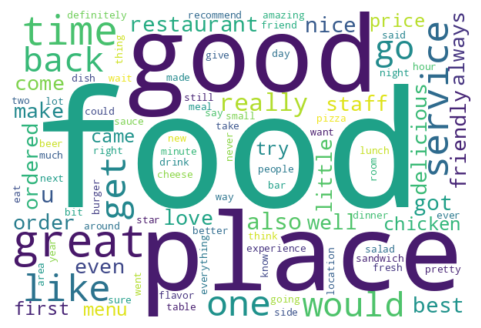

In [39]:
# WordCloud: Plot with top 100 words
# Flatten the word lists and concatenate them into a single string
word_freq = {}
for (word, count) in top_100_words:
  word_freq[word] = count

# Create a word cloud from the concatenated text
wordcloud = WordCloud(width=600, height=400, background_color='white', max_words=100).generate_from_frequencies(word_freq)

# Display the generated word cloud image
plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

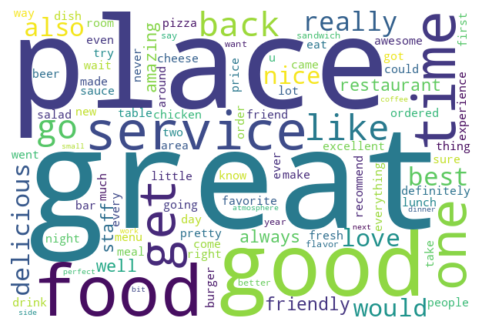

In [40]:
# WordCloud: Plot with top 100 words - positive
# Flatten the word lists and concatenate them into a single string
word_freq_pos = {}
for (word, count) in top_pos_100_words:
  word_freq_pos[word] = count

# Create a word cloud from the concatenated text
wordcloud_pos = WordCloud(width=600, height=400, background_color='white', max_words=100).generate_from_frequencies(word_freq_pos)

# Display the generated word cloud image
plt.figure(figsize=(6, 4))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.show()

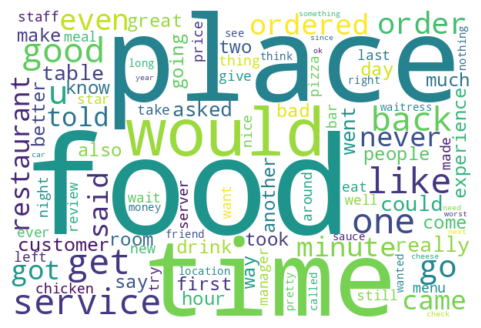

In [42]:
# WordCloud: Plot with top 100 words - negative
# Flatten the word lists and concatenate them into a single string
word_freq_neg = {}
for (word, count) in top_neg_100_words:
  word_freq_neg[word] = count

# Create a word cloud from the concatenated text
wordcloud_neg = WordCloud(width=600, height=400, background_color='white', max_words=100).generate_from_frequencies(word_freq_neg)

# Display the generated word cloud image
plt.figure(figsize=(6, 4))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.show()

In [55]:
stars_and_feedbacks = review_rdd.map(lambda x: (int(x[0]), (x[1], x[2], x[3])))

def filter_no_feedbacks(row):
  return row[1] != 0 or row[2] != 0 or row[3] != 0
stars_and_feedbacks = stars_and_feedbacks.filter(filter_no_feedbacks)

for row in stars_and_feedbacks.take(10):
  print(row)

(3, (0, 0, 0))
(5, (1, 0, 1))
(3, (0, 0, 0))
(5, (1, 0, 1))
(4, (1, 0, 1))
(1, (1, 2, 1))
(5, (0, 2, 0))
(5, (2, 0, 0))
(3, (1, 1, 0))
(3, (0, 0, 0))


In [56]:
stars_and_feedbacks_grouped_rdd = stars_and_feedbacks.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2]))
for row in stars_and_feedbacks_grouped_rdd.collect():
  print(row)

(1, (1790173, 452007, 165144))
(2, (737035, 232216, 140806))
(3, (817203, 276943, 326897))
(4, (1793423, 552487, 1079434))
(5, (3142914, 769090, 1773195))
